# RL Open Source Fest Application Exercise 2021
> ## Python / Data Science Exercise
> Analysis how non-stationarity affects different Contextual Bandit algorithms

>> Changing the reward distribution over time and adding varying noise

>> Comparing the results of different exploration algorithms

> My code in based on the Simulating Content Personalization with Contextual Bandits Vowpal Wabbit tutorial  https://vowpalwabbit.org/tutorials/cb_simulation.html.

## Created by Mónika Farsang





### Installing and importing libraries

In [1]:
# Install Vowpal Wabbit package
!pip install boost
!apt-get install libboost-program-options-dev zlib1g-dev libboost-python-dev -y
!pip install vowpalwabbit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-program-options-dev is already the newest version (1.65.1.0ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libboost-python-dev is already the newest version (1.65.1.0ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [2]:
# Import libraries
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

### Getting decision from VW

In [3]:
# Modify context, action, cost, and probability to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [4]:
# Sample from the list and return the index and the probability
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [5]:
# Return the action and the probability
def get_action(vw, context, actions):
    # Convert the context and the actions
    vw_text_example = to_vw_example_format(context,actions)
    # Get the PMF output
    pmf = vw.predict(vw_text_example)
    # Sample the PMF and get index plus probability
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

### Reinforcement learning setup

In [6]:
# Define users, time of day and actions
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

# Choose between the users uniformly at random
def choose_user(users):
    return random.choice(users)

# Choose between the times uniformly at random
def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

### Plotting function

In [7]:
# Plot the click-through rate
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.title('Comparing exploration algorithms performance', fontsize=18)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# Second scenario with changing preferences

### Defining cost and random noise

In [8]:
# VW tries to minimize loss/cost, therefore cost is passed as -reward 
USER_LIKED_ARTICLE = -1.0 
USER_DISLIKED_ARTICLE = 0.0

In [9]:
# Add random noise (negative), it is divided by 10 to scale down to (-0.1;0]
def add_noise():
  return -random.random()/10

### Defining different reward functions

In [10]:
# Define the initial reward function: Tom likes politics in the morning and music in the afternoon. Anna likes sports in the morning and politics in the afternoon.
def define_cost_function(morning_action1, afternoon_action1, morning_action2, afternoon_action2):
  def get_cost_part(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == morning_action1:
            return USER_LIKED_ARTICLE + add_noise()
        elif context['time_of_day'] == "afternoon" and action == afternoon_action1:
            return USER_LIKED_ARTICLE + add_noise()
        else:
            return USER_DISLIKED_ARTICLE + add_noise()
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == morning_action2:
            return USER_LIKED_ARTICLE + add_noise()
        elif context['time_of_day'] == "afternoon" and action == afternoon_action2:
            return USER_LIKED_ARTICLE + add_noise()
        else:
            return USER_DISLIKED_ARTICLE + add_noise()
  return get_cost_part

### Simulation for multiple reward functions

In [11]:
# Run simulation with multiple reward functions
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. Choose a user in each simulation
            user = choose_user(users)
            # 2. Choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

### Plotting and comparing different exploration strategies

In [12]:
# Use different exploration algorithms
vws=[]
strategy_names=[]
# 0. Without learning (as a baseline)
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --first 2"))
strategy_names.append('Without learning')
# 1. Explore-first
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --first 2"))
strategy_names.append('Explore-first (2)')
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --first 4"))
strategy_names.append('Explore-first (4)')
# 2. Epsilon-greedy
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1"))
strategy_names.append('Epsilon-greedy (0.1)')
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2"))
strategy_names.append('Epsilon-greedy (0.2)')
# 3. Bagging Explorer
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5"))
strategy_names.append('Bagging Explorer (5)')
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --bag 10"))
strategy_names.append('Bagging Explorer (10)')
# 4. Softmax Explorer
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10"))
strategy_names.append('Softmax Explorer (10)')
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 15"))
strategy_names.append('Softmax Explorer (15)')
# 5. RND  Explorer
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025"))
strategy_names.append('RND  Explorer (3, 0.025)')
vws.append(pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 5 --epsilon 0.05"))
strategy_names.append('RND  Explorer (5, 0.05)')

In [13]:
# Define iteration number and cost functions
num_iterations_per_cost_func = 2000

# Possible actions: actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]
cost_functions = [define_cost_function(actions[0], actions[2], actions[1], actions[0]), #'politics','music','sports','politics'
                  define_cost_function(actions[0], actions[1], actions[1], actions[1]), #'politics','sports','sports','sports'
                  define_cost_function(actions[2], actions[1], actions[3], actions[1]), #'music','sports','food','sports'
                  define_cost_function(actions[2], actions[4], actions[3], actions[5]), #'music','finance','food','health'
                  define_cost_function(actions[4], actions[4], actions[3], actions[6])] #'finance','finance','food','camping'
total_iterations = num_iterations_per_cost_func * len(cost_functions)

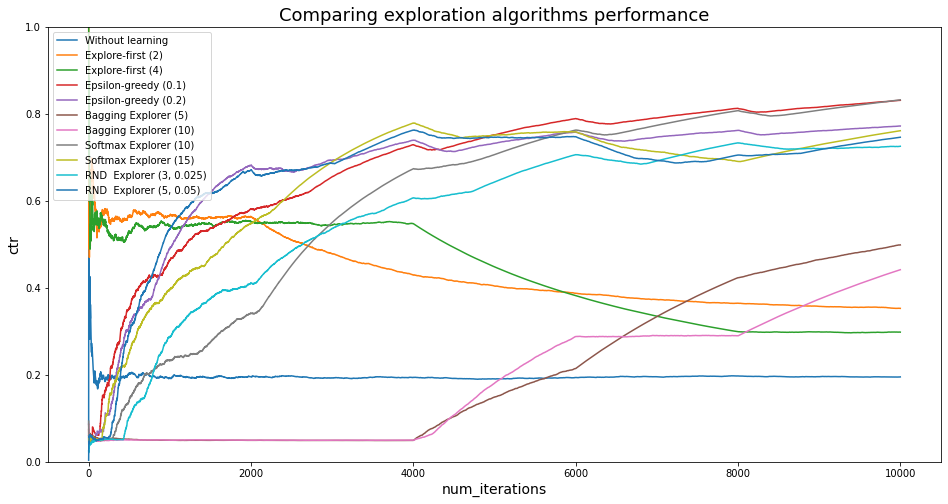

In [16]:
# Create plot
plt.figure(figsize=(16,8))
# Plot baseline without learning
ctr_no_learning = run_simulation_multiple_cost_functions(vws[0], num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr_no_learning)
# Plot exploration algorithms with learning
for vw in vws[1:]:
  ctr=(run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions))
  plot_ctr(total_iterations, ctr)
plt.legend(strategy_names)

##### Note: Each exploration algorithm is analyzed with 2 different parameters, which specific value are presented in the brackets. After each run, the results can be a bit different due to the randomness of the rewards and the simulator.

With this simulation, I found that it highly varied how exploration algorithms were able to adapt to the changing preferences over time. Some of them struggled at the beginning, like the Explore-first (2) and the Bagging Explorer (10), but even with this, they achieved a higher click-through rate than the "Without learning" baseline. However, these algorithms with higher parameters - Explore-first (4) and the Bagging Explorer (5) - got impressive results in the first 2000 iteration but later they performance decreased. Undoubtedly, the best learners in this task were the RND explorer, the Epsilon-greedy and the Softmax Explorer, which were able to respond to the simulated real-world changes.